## Introduction And Objective

## Importing Libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
#Load and Read the dataset
data = pd.read_csv('exoplanet_data.csv')

## Data Preprocessing and cleaning

In [7]:
data.shape

(5250, 13)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250 entries, 0 to 5249
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               5250 non-null   object 
 1   distance           5233 non-null   float64
 2   stellar_magnitude  5089 non-null   float64
 3   planet_type        5250 non-null   object 
 4   discovery_year     5250 non-null   int64  
 5   mass_multiplier    5227 non-null   float64
 6   mass_wrt           5227 non-null   object 
 7   radius_multiplier  5233 non-null   float64
 8   radius_wrt         5233 non-null   object 
 9   orbital_radius     4961 non-null   float64
 10  orbital_period     5250 non-null   float64
 11  eccentricity       5250 non-null   float64
 12  detection_method   5250 non-null   object 
dtypes: float64(7), int64(1), object(5)
memory usage: 533.3+ KB


In [9]:
data.head(5)

,name,distance,stellar_magnitude,planet_type,discovery_year,mass_multiplier,mass_wrt,radius_multiplier,radius_wrt,orbital_radius,orbital_period,eccentricity,detection_method
0,11 Comae Berenices b,304.0,4.72307,Gas Giant,2007,19.40000,Jupiter,1.08,Jupiter,1.290000,0.892539,0.23,Radial Velocity
1,11 Ursae Minoris b,409.0,5.01300,Gas Giant,2009,14.74000,Jupiter,1.09,Jupiter,1.530000,1.400000,0.08,Radial Velocity
2,14 Andromedae b,246.0,5.23133,Gas Giant,2008,4.80000,Jupiter,1.15,Jupiter,0.830000,0.508693,0.00,Radial Velocity
3,14 Herculis b,58.0,6.61935,Gas Giant,2002,8.13881,Jupiter,1.12,Jupiter,2.773069,4.800000,0.37,Radial Velocity
4,16 Cygni B b,69.0,6.21500,Gas Giant,1996,1.78000,Jupiter,1.20,Jupiter,1.660000,2.200000,0.68,Radial Velocity


In [10]:
# Identify categorical and numerical columns
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

# Print the identified columns
print("Categorical Columns:")
print(categorical_columns)
print("\nNumerical Columns:")
print(numerical_columns)

Categorical Columns:
Index(['name', 'planet_type', 'mass_wrt', 'radius_wrt', 'detection_method'], dtype='object')

Numerical Columns:
Index(['distance', 'stellar_magnitude', 'discovery_year', 'mass_multiplier',
       'radius_multiplier', 'orbital_radius', 'orbital_period',
       'eccentricity'],
      dtype='object')


In [11]:
data.isnull().sum()

name                   0
distance              17
stellar_magnitude    161
planet_type            0
discovery_year         0
mass_multiplier       23
mass_wrt              23
radius_multiplier     17
radius_wrt            17
orbital_radius       289
orbital_period         0
eccentricity           0
detection_method       0
dtype: int64

In [12]:
#Drop Unnecessary Columns
data.drop(columns=["stellar_magnitude"], inplace=True)

#Fill Missing Distance with Median
data["distance"] = data["distance"].fillna(data["distance"].median())

## Feature Selection

### Estimating Missing Orbital Radius using Kepler’s Third Law
Kepler’s Third Law states that the ratio T^2/R^3 is a constant for all planets.
The constant C is computed from known data and used to estimate missing values of orbital_radius.

### Standardizing Mass and Radius to Earth Units
Planets have mass and radius referenced to either Earth or Jupiter.
Mass and radius are converted to Earth units using:
1. Jupiter Mass = 317.82838 × Earth Mass
2. Jupiter Radius = 11.209 × Earth Radius

In [14]:
display(data['mass_wrt'].value_counts())
display(data['radius_wrt'].value_counts())

mass_wrt
Earth      3586
Jupiter    1641
Name: count, dtype: int64

radius_wrt
Jupiter    3310
Earth      1923
Name: count, dtype: int64

In [15]:
#Estimate Missing Orbital Radius using Kepler’s Third Law
known_data = data.dropna(subset=["orbital_radius", "orbital_period"])
C = np.median((known_data["orbital_period"]**2) / (known_data["orbital_radius"]**3))

def estimate_orbital_radius(row):
    if np.isnan(row["orbital_radius"]):
        return ((row["orbital_period"]**2) / C) ** (1/3)
    return row["orbital_radius"]

data["orbital_radius"] = data.apply(estimate_orbital_radius, axis=1)

# Fill Missing Mass and Radius Multipliers Using Median per Planet Type
for col in ["mass_multiplier", "radius_multiplier"]:
    data[col] = data.groupby("planet_type")[col].transform(lambda x: x.fillna(x.median()))

#Standardize Mass and Radius to Earth Units
#Jupiter is 317.82838 times as massive as Earth
def calc_mass_earth(x):
    if x["mass_wrt"] == "Earth":
        return x["mass_multiplier"]
    elif x["mass_wrt"] == "Jupiter":
        return x["mass_multiplier"] * 317.82838

# Jupiters radius is 11.209 times larger than Earths radius
def calc_radius_earth(x):
    if x["radius_wrt"] == "Earth":
        return x["radius_multiplier"]
    elif x["radius_wrt"] == "Jupiter":
        return x["radius_multiplier"] * 11.209 

data["mass_earth"] = data.apply(calc_mass_earth, axis=1)
data["radius_earth"] = data.apply(calc_radius_earth, axis=1)

#Drop Old Columns No Longer Needed
data.drop(columns=["mass_wrt", "radius_wrt"], inplace=True)

#Check for Remaining Null Values
print(data.isnull().sum())

name                  0
distance              0
planet_type           0
discovery_year        0
mass_multiplier       5
radius_multiplier     5
orbital_radius        0
orbital_period        0
eccentricity          0
detection_method      0
mass_earth           23
radius_earth         17
dtype: int64


## Visualization
(Between Different Parameters)

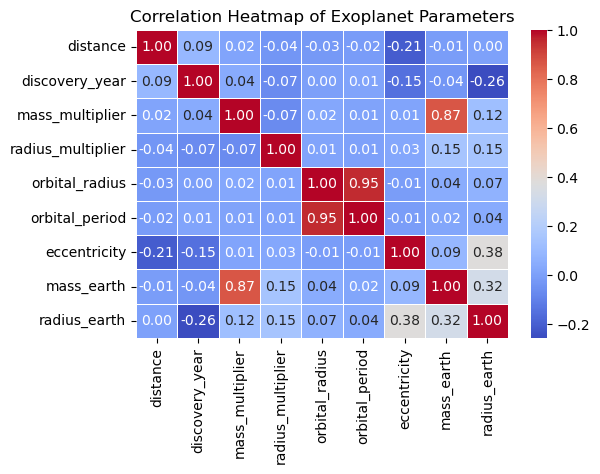

In [17]:
# visualize the correlation between the parameters
corr_matrix = data.select_dtypes(include=['number']).corr()
fig, ax = plt.subplots(figsize=(6,4))  
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=ax)
plt.title("Correlation Heatmap of Exoplanet Parameters")
plt.show()

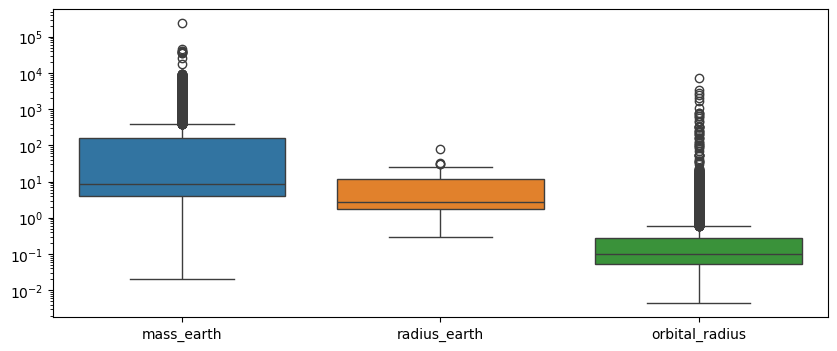

In [18]:
plt.figure(figsize=(10,4))
sns.boxplot(data=data[['mass_earth', 'radius_earth', 'orbital_radius']])
plt.yscale("log")  # Log scale to handle wide ranges
plt.show()

The log-scaled box plot shows the spread and outliers for mass_earth, radius_earth, and orbital_radius. Here's what we observe:

Mass (mass_earth)
- Most planets have masses between 1 and 1000 Earth masses.
- A few extreme outliers exist above 10,000 Earth masses.

Radius (radius_earth)
- Most planets have radii between 0.5 and 10 Earth radii.
- A few outliers are above 20 Earth radii (likely gas giants).

Orbital Radius (orbital_radius)
- The distribution is very spread out.
- Most values are below 1 AU, but there are some extreme outliers above 10 AU.

### Discovery Year Insights

In [21]:
discovery_counts = data['discovery_year'].value_counts()
display(discovery_counts)

discovery_year
2016    1517
2014     875
2021     525
2022     338
2018     326
2020     234
2019     203
2015     157
2017     153
2012     138
2011     138
2013     126
2010      97
2009      94
2008      65
2007      52
2005      36
2006      31
2002      29
2004      27
2003      22
2000      16
1999      13
2001      12
2023       9
1996       6
1998       6
1992       2
1995       1
1994       1
1997       1
Name: count, dtype: int64

In [22]:
# Set threshold (ignore years with < 15 discoveries)
discovery_counts = discovery_counts[discovery_counts >= 15]

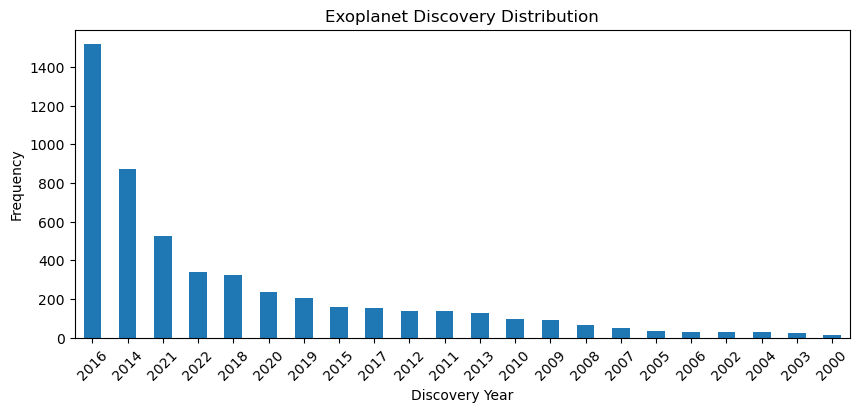

In [23]:
# Plot the bar chart
plt.figure(figsize=(10, 4))
discovery_counts.plot(kind='bar')
plt.xlabel('Discovery Year')
plt.ylabel('Frequency')
plt.title('Exoplanet Discovery Distribution')
# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### Exoplanet Detection Method Insights

In [25]:
detection_counts = data['detection_method'].value_counts()
display(detection_counts)

detection_method
Transit                          3945
Radial Velocity                  1027
Gravitational Microlensing        154
Direct Imaging                     62
Transit Timing Variations          24
Eclipse Timing Variations          17
Orbital Brightness Modulation       9
Pulsar Timing                       7
Astrometry                          2
Pulsation Timing Variations         2
Disk Kinematics                     1
Name: count, dtype: int64

In [26]:
# Define threshold
# Detection counts gives us (Gravitational Microlensing = 154 > 100) and (Direct Imaging = 64 < 100) hence
threshold = 100

# Identify rare methods
rare_methods = detection_counts[detection_counts < threshold].index

# Replace them with "Other"
data['detection_method'] = data['detection_method'].replace(rare_methods, 'Other')

# Check the updated counts
detection_counts = data['detection_method'].value_counts()
display(detection_counts)

detection_method
Transit                       3945
Radial Velocity               1027
Gravitational Microlensing     154
Other                          124
Name: count, dtype: int64

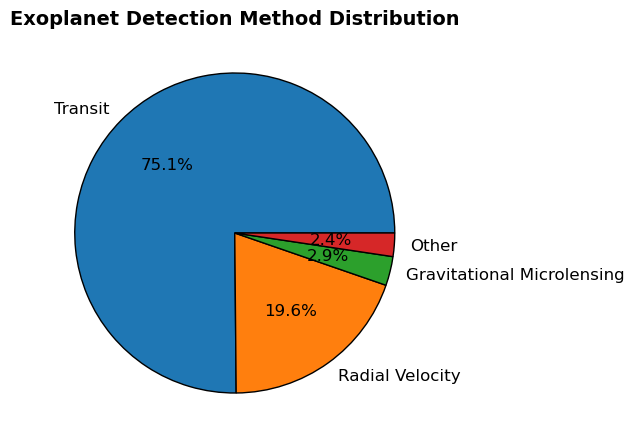

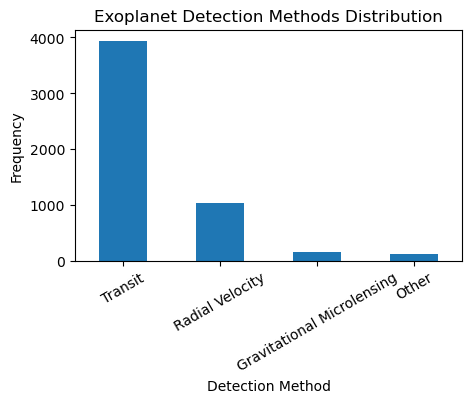

In [27]:
# Define colors for better distinction
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
# Plot pie chart
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(detection_counts, labels=detection_counts.index, autopct=lambda p: f'{p:.1f}%' if p > 1 else '', 
       colors=colors[:len(detection_counts)], textprops={'fontsize': 12}, wedgeprops={'edgecolor': 'black'})
# Title formatting
ax.set_title("Exoplanet Detection Method Distribution", fontsize=14, fontweight='bold')
# Adjust layout for better visibility
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Show the plot
plt.show()
plt.figure(figsize=(5, 3))
detection_counts.plot(kind='bar')
plt.xlabel('Detection Method')
plt.ylabel('Frequency')
plt.title('Exoplanet Detection Methods Distribution')
plt.xticks(rotation=30)
plt.show()

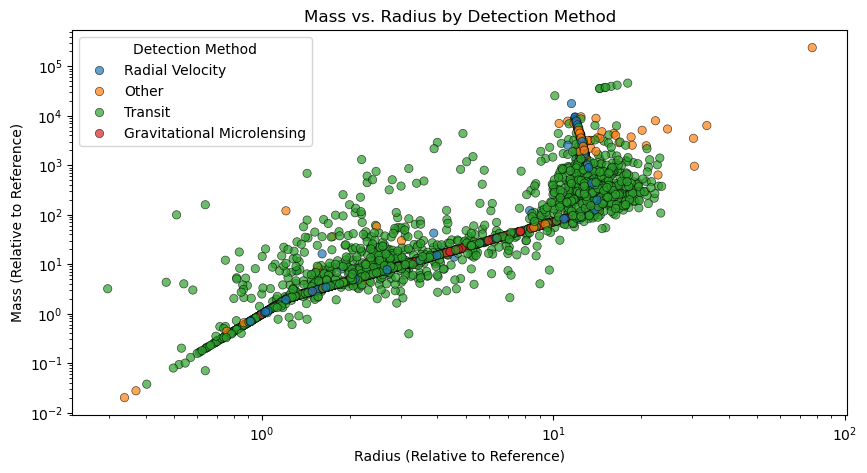

In [28]:
# Mass vs. Radius by Detection Method
plt.figure(figsize=(10, 5))
sns.scatterplot(data=data, x='radius_earth', y='mass_earth', hue='detection_method', alpha=0.7, edgecolor='black', palette="tab10")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Radius (Relative to Reference)")
plt.ylabel("Mass (Relative to Reference)")
plt.title("Mass vs. Radius by Detection Method")
plt.legend(title="Detection Method")
# plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Detection Method and Discovery Timeline


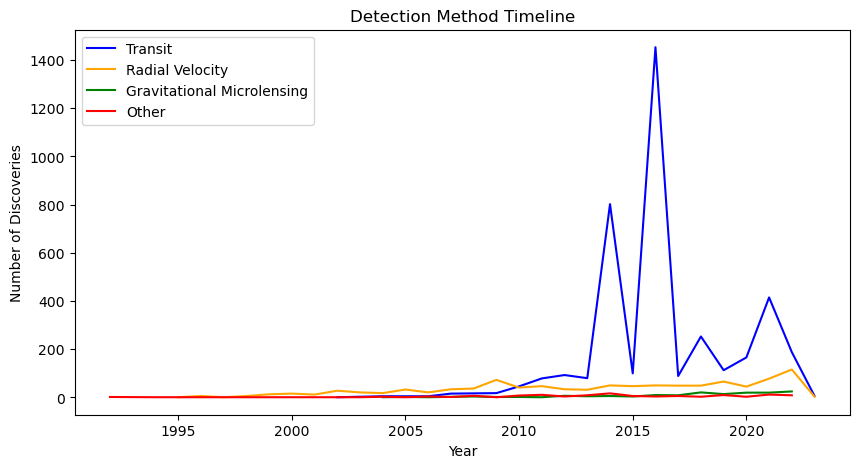

In [30]:
# Define detection methods
methods = ['Transit', 'Radial Velocity', 'Gravitational Microlensing', 'Other']
colors = ['blue', 'orange', 'green', 'red']

plt.figure(figsize=(10, 5))

# Loop through methods and plot
for method, color in zip(methods, colors):
    method_counts = data[data['detection_method'] == method]['discovery_year'].value_counts().sort_index()
    plt.plot(method_counts.index, method_counts.values, label=method, color=color)

# Labels and title
plt.title('Detection Method Timeline')
plt.xlabel('Year')
plt.ylabel('Number of Discoveries')
plt.legend()
plt.show()


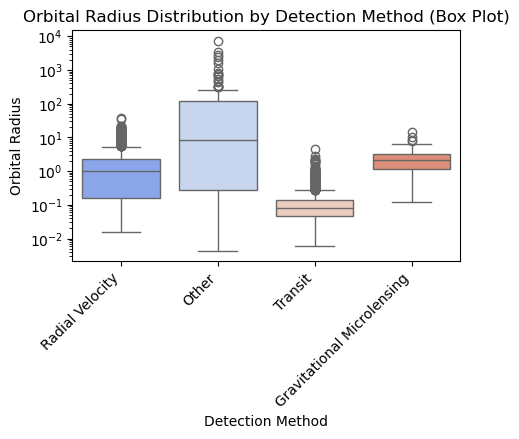

In [31]:
# # Violin and Box Plots for Orbital Radius by Detection Method
# plt.figure(figsize=(5, 3))
# sns.violinplot(data=data, x='detection_method', y='orbital_radius', hue='detection_method', palette="muted", inner="quartile")
# plt.xticks(rotation=45, ha='right')
# plt.xlabel("Detection Method")
# plt.ylabel("Orbital Radius")
# plt.title("Orbital Radius Distribution by Detection Method (Violin Plot)")
# plt.yscale("log")
# plt.show()

plt.figure(figsize=(5, 3))
sns.boxplot(data=data, x='detection_method', y='orbital_radius', hue = 'detection_method', palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Detection Method")
plt.ylabel("Orbital Radius")
plt.title("Orbital Radius Distribution by Detection Method (Box Plot)")
plt.yscale("log")
plt.show()

The violin and box plots indicate that:
- Radial Velocity & Gravitational Microlensing mainly detect planets with moderate orbital radii.
- Transit method focuses on close-orbiting planets.
-Other methods cover a broad range, including distant planets.
- There are significant variations in detected orbital radii across methods, with outliers suggesting rare long-orbit exoplanets.

### Exoplanet Planet Type Insights

In [34]:
planet_counts = data['planet_type'].value_counts()
display(planet_counts)

planet_type
Neptune-like    1825
Gas Giant       1630
Super Earth     1595
Terrestrial      195
Unknown            5
Name: count, dtype: int64

In [35]:
# Remove categories with fewer than 10 occurrences
planet_counts = planet_counts[planet_counts >= 150]
display(planet_counts)

planet_type
Neptune-like    1825
Gas Giant       1630
Super Earth     1595
Terrestrial      195
Name: count, dtype: int64

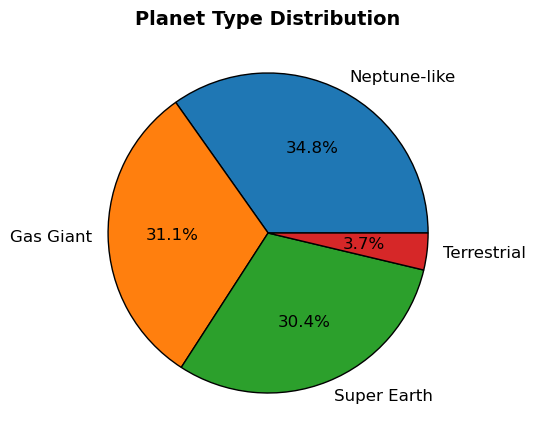

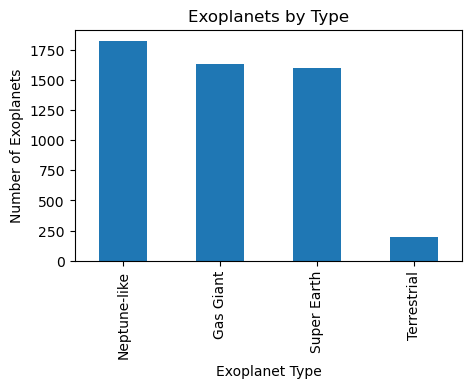

In [36]:
# Define colors for better distinction
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
# Plot pie chart
fig, ax = plt.subplots(figsize=(6, 5))
ax.pie(planet_counts, labels=planet_counts.index, autopct=lambda p: f'{p:.1f}%' if p > 1 else '', 
       colors=colors, textprops={'fontsize': 12}, wedgeprops={'edgecolor': 'black'})
# Title formatting
ax.set_title("Planet Type Distribution", fontsize=14, fontweight='bold')
# Adjust layout for better visibility
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
# Show the plot
plt.show()

#Bar Chart
plt.figure(figsize=(5, 3))
planet_counts.plot(kind='bar')
plt.xlabel('Exoplanet Type')
plt.ylabel('Number of Exoplanets')
plt.title('Exoplanets by Type')
plt.show()


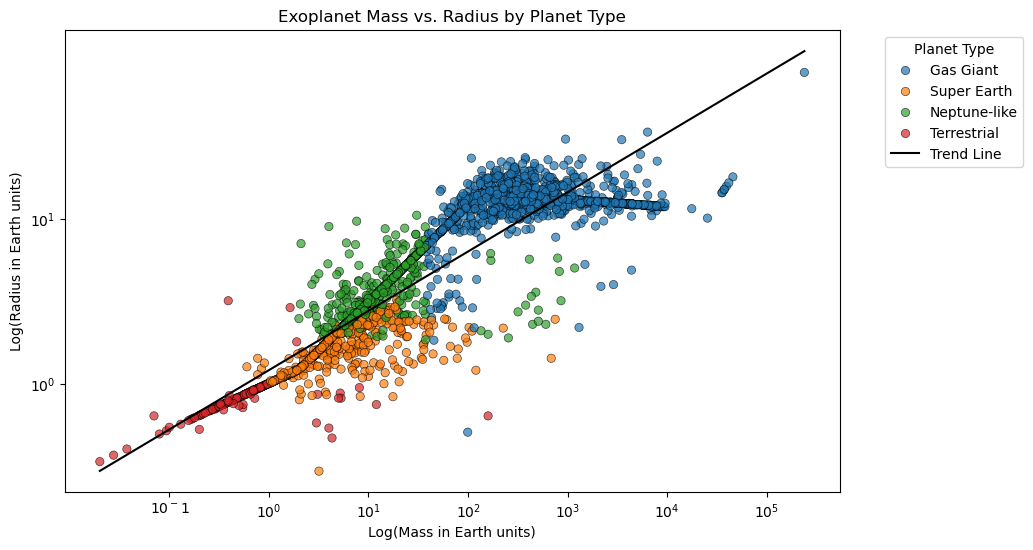

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Ensure no zero or negative values before log transformation
data = data[(data['mass_earth'] > 0) & (data['radius_earth'] > 0)]

# Compute logarithmic values
data['log_mass'] = np.log10(data['mass_earth'])
data['log_radius'] = np.log10(data['radius_earth'])

plt.figure(figsize=(10, 6))

# Scatter plot (Mass vs Radius colored by Planet Type)
sns.scatterplot(
    x=data['log_mass'], 
    y=data['log_radius'], 
    hue=data['planet_type'], 
    alpha=0.7,
    edgecolor='k'
)

# Compute trend line
slope, intercept, _, _, _ = linregress(data['log_mass'], data['log_radius'])
x_vals = np.linspace(data['log_mass'].min(), data['log_mass'].max(), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='black', linestyle='solid', label='Trend Line')

# Labels and title
plt.xlabel('Log(Mass in Earth units)')
plt.ylabel('Log(Radius in Earth units)')
plt.title('Exoplanet Mass vs. Radius by Planet Type')
plt.legend(title='Planet Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust axis ticks to show values in powers of 10
plt.xticks(ticks=np.arange(int(data['log_mass'].min()), int(data['log_mass'].max()) + 1), 
           labels=[f'$10^{x}$' for x in np.arange(int(data['log_mass'].min()), int(data['log_mass'].max()) + 1)])
plt.yticks(ticks=np.arange(int(data['log_radius'].min()), int(data['log_radius'].max()) + 1), 
           labels=[f'$10^{x}$' for x in np.arange(int(data['log_radius'].min()), int(data['log_radius'].max()) + 1)])

plt.show()

Mass-Radius Relationship:
- A positive correlation exists: larger mass generally means a larger radius.
- The relationship follows a power-law trend (𝑅 ∝ 𝑀^𝑛) rather than a simple linear one.

Planet Type Clustering:
- Terrestrial Planets (Red): Small mass (<1 Earth mass) and radius (<1 Earth radius), mostly rocky.
- Super-Earths (Orange): Intermediate size, mix of rocky and gaseous composition.
- Neptune-like Planets (Green): Larger than Super-Earths, gaseous in nature.
- Gas Giants (Blue): Largest in mass and radius but grow at a diminishing rate due to atmospheric compression.

Trend Line Insights:
- The trend line shows a sub-linear mass-radius relationship (slope < 1).

Deviations from the Trend:
- Above trend line: Large radius for mass → Low-density, gas-rich planets (e.g., puffy exoplanets).
- Below trend line: Small radius for mass → High-density, rocky planets (e.g., iron-rich planets).

### Machine Learning Model

In [40]:
#Encoding Planet_type for further ML Model
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply encoding
data['planet_type_encoded'] = label_encoder.fit_transform(data['planet_type'])

# Display mapping of labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:", label_mapping)

Label Encoding Mapping: {'Gas Giant': 0, 'Neptune-like': 1, 'Super Earth': 2, 'Terrestrial': 3}


In [41]:
data[['planet_type', 'planet_type_encoded']].tail()

,planet_type,planet_type_encoded
5245,Gas Giant,0
5246,Gas Giant,0
5247,Terrestrial,3
5248,Super Earth,2
5249,Super Earth,2


In [42]:
# Define feature set (independent variables)
X = data[['mass_earth', 'radius_earth', 'orbital_radius']]

# Define target variable (dependent variable)
y = data['planet_type_encoded']

# Check for missing values
print(X.isnull().sum())

# Fill missing values with median (better for skewed distributions)
X = X.fillna(X.median())

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

mass_earth        0
radius_earth      0
orbital_radius    0
dtype: int64


In [43]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Check the shape of the datasets
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 4172 samples
Testing set size: 1043 samples


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Detailed classification report
print(classification_report(y_test, y_pred))

Model Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       320
           1       0.97      0.98      0.98       365
           2       0.98      0.97      0.97       319
           3       0.97      0.97      0.97        39

    accuracy                           0.98      1043
   macro avg       0.98      0.98      0.98      1043
weighted avg       0.98      0.98      0.98      1043



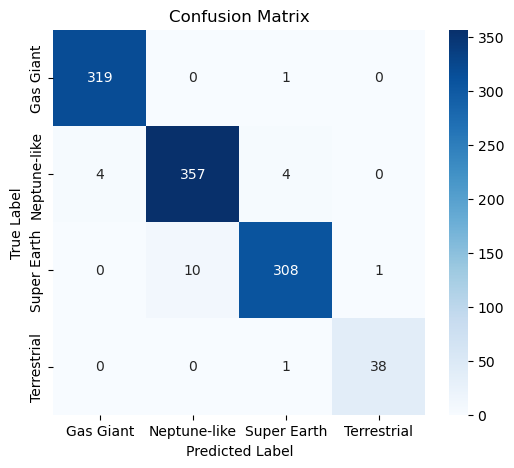

In [45]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

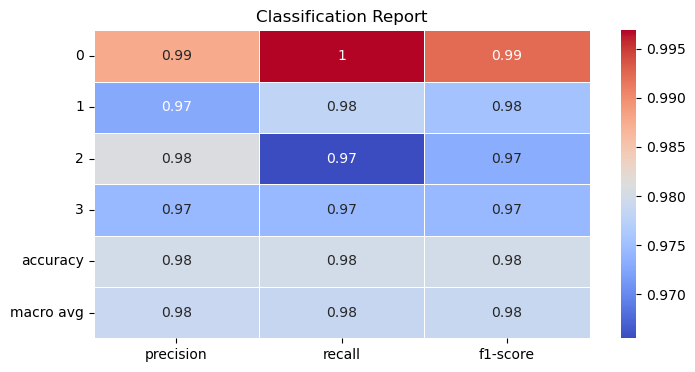

In [46]:
import pandas as pd
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Classification Report")
plt.show()

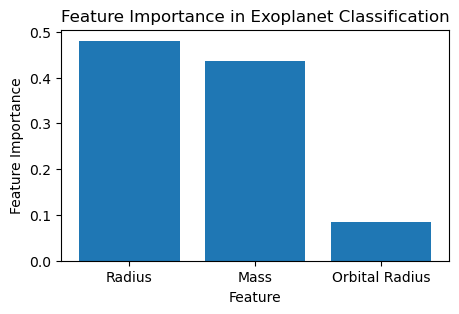

In [47]:
importances = model.feature_importances_
feature_names = ['Mass', 'Radius', 'Orbital Radius']

# Sort features by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(5, 3))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices])
plt.ylabel("Feature Importance")
plt.xlabel("Feature")
plt.title("Feature Importance in Exoplanet Classification")
plt.show()

In [48]:
from sklearn.model_selection import cross_val_score, KFold

# Define K-Fold strategy
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validation
cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

# Print results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

Cross-validation scores: [0.98465964 0.97698945 0.98178332 0.98753595 0.98274209]
Mean Accuracy: 0.9827
Standard Deviation: 0.0035


## Habitability Analysis

In [50]:
# # Define habitability criteria
# habitable_planets = data[
#     (data['radius_earth'] >= 0.5) & (data['radius_earth'] <= 2) &  # Earth-like radius
#     (data['mass_earth'] >= 0.1) & (data['mass_earth'] <= 5) &      # Earth-like mass
#     (data['orbital_radius'] >= 0.38) & (data['orbital_radius'] <= 1.5) &  # Habitable zone
#     (data['eccentricity'] <= 0.2)   # Stable orbit
# ]

# # Display the first few results
# print("Potentially Habitable Exoplanets:\n")
# print(habitable_planets[['planet_type', 'mass_earth', 'radius_earth', 'orbital_radius', 'eccentricity']])
# print(habitable_planets.shape[0])  # Number of habitable planets

# Define relaxed habitability criteria
habitable_planets = data[
    (data['radius_earth'] >= 0.5) & (data['radius_earth'] <= 2.5) &  # Slightly larger planets
    (data['mass_earth'] >= 0.1) & (data['mass_earth'] <= 10) &      # Allow Super-Earths
    (data['orbital_radius'] >= 0.38) & (data['orbital_radius'] <= 2.0) &  # Slightly wider habitable zone
    (data['eccentricity'] <= 0.2)   # Stable orbit
]
# Display updated habitable planet count
print("Number of Potentially Habitable Exoplanets:", len(habitable_planets))

Number of Potentially Habitable Exoplanets: 58


In [51]:
# Add a 'habitable' column to the dataset (1 for habitable, 0 for non-habitable)
data['habitable'] = (
    (data['radius_earth'] >= 0.5) & (data['radius_earth'] <= 2.5) &  
    (data['mass_earth'] >= 0.1) & (data['mass_earth'] <= 10) &      
    (data['orbital_radius'] >= 0.38) & (data['orbital_radius'] <= 2.0) &  
    (data['eccentricity'] <= 0.2)
).astype(int)

# Check new column
print(data['habitable'].value_counts())
print(data[['planet_type', 'mass_earth', 'radius_earth', 'orbital_radius', 'eccentricity', 'habitable']].head())

habitable
0    5157
1      58
Name: count, dtype: int64
  planet_type   mass_earth  radius_earth  orbital_radius  eccentricity  \
0   Gas Giant  6165.870572      12.10572        1.290000          0.23   
1   Gas Giant  4684.790321      12.21781        1.530000          0.08   
2   Gas Giant  1525.576224      12.89035        0.830000          0.00   
3   Gas Giant  2586.744797      12.55408        2.773069          0.37   
4   Gas Giant   565.734516      13.45080        1.660000          0.68   

   habitable  
0          0  
1          0  
2          0  
3          0  
4          0  


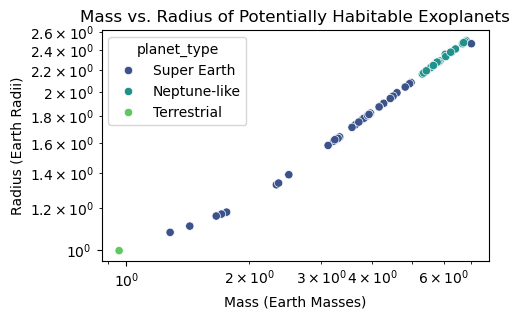

In [52]:
# Scatter plot: Mass vs. Radius
plt.figure(figsize=(5, 3))
sns.scatterplot(data=habitable_planets, x='mass_earth', y='radius_earth', hue='planet_type', palette='viridis')
plt.xlabel("Mass (Earth Masses)")
plt.ylabel("Radius (Earth Radii)")
plt.title("Mass vs. Radius of Potentially Habitable Exoplanets")
plt.xscale('log')  # Log scale for better visualization if needed
plt.yscale('log')
plt.show()

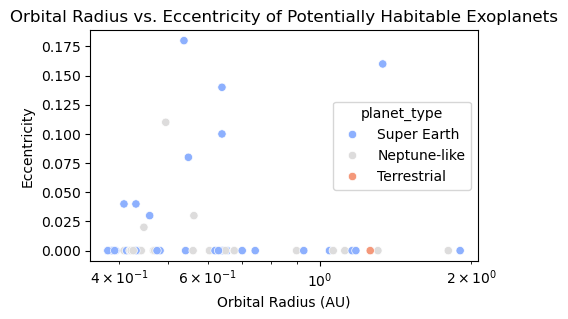

In [53]:
# Scatter plot: Orbital Radius vs. Eccentricity
plt.figure(figsize=(5, 3))
sns.scatterplot(data=habitable_planets, x='orbital_radius', y='eccentricity', hue='planet_type', palette='coolwarm')
plt.xlabel("Orbital Radius (AU)")
plt.ylabel("Eccentricity")
plt.title("Orbital Radius vs. Eccentricity of Potentially Habitable Exoplanets")
plt.xscale('log')
plt.show()

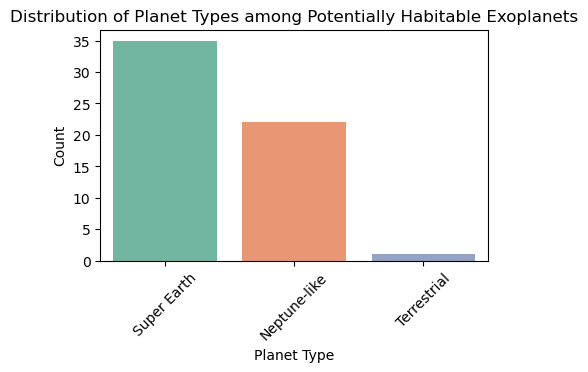

In [54]:
# Bar plot: Distribution of Planet Types in Habitable Candidates
plt.figure(figsize=(5, 3))
sns.countplot(data=habitable_planets, x='planet_type',hue = 'planet_type', palette='Set2')
plt.xlabel("Planet Type")
plt.ylabel("Count")
plt.title("Distribution of Planet Types among Potentially Habitable Exoplanets")
plt.xticks(rotation=45)
plt.show()

Analysis of Potentially Habitable Exoplanets


### Mass vs. Radius Analysis
- Majority of potentially habitable planets are **Super Earths**.
- A few **Neptune-like** planets appear, indicating they may be at the upper size limit of habitability.
- **Terrestrial planets are rare**, suggesting the criteria favor larger pts.

### Orbital Radius vs. Eccentricity
- Most planets have **low eccentricity**, making them stable for habitability.
- A few outliers with **higher eccentricity** could experience significant climate variations.
- Super Earths dominate this range, with a small number of Neptune-like and terrestrplanets.

### Distribution of Planet Types
- **Super Earths (~35 planets)** form the largest share of potentially habitable planets.
- **Neptune-like planets (~20 planets)** are present, though their true habitability is uncertain.
- **Terrestrial planets (~3 planets)** are rare, suggesting stringent criteria might be excluding Eiscovered exoplanets.


In [56]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Define features and target
X = data[['mass_earth', 'radius_earth', 'orbital_radius', 'eccentricity']]
y = data['habitable']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree Classifier
dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_clf.fit(X_train, y_train)

# Predict on test data
y_pred = dt_clf.predict(X_test)

# Evaluate performance
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Decision Tree Accuracy: 0.9990412272291467
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1031
           1       0.92      1.00      0.96        12

    accuracy                           1.00      1043
   macro avg       0.96      1.00      0.98      1043
weighted avg       1.00      1.00      1.00      1043



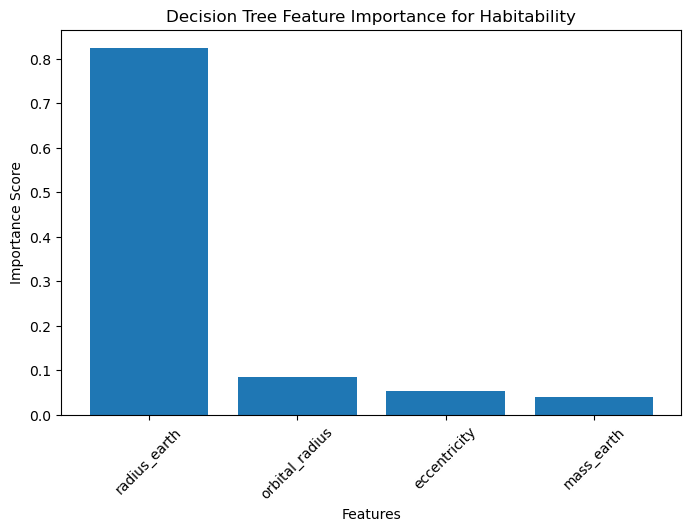

In [57]:
# Get feature importance
feature_importance = dt_clf.feature_importances_
features = X_train.columns  # Features used in the model

# Sort features by importance
sorted_idx = np.argsort(feature_importance)[::-1]

# Plot feature importance
plt.figure(figsize=(8, 5))
plt.bar(range(len(features)), feature_importance[sorted_idx], align="center")
plt.xticks(range(len(features)), np.array(features)[sorted_idx], rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Decision Tree Feature Importance for Habitability")
plt.show()

<Figure size 400x300 with 0 Axes>

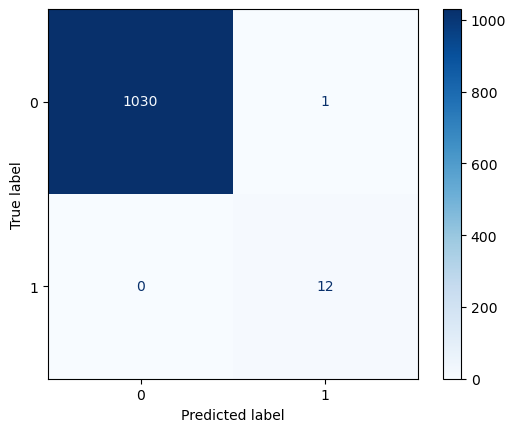

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display matrix
plt.figure(figsize=(4,3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_clf.classes_)
disp.plot(cmap="Blues")

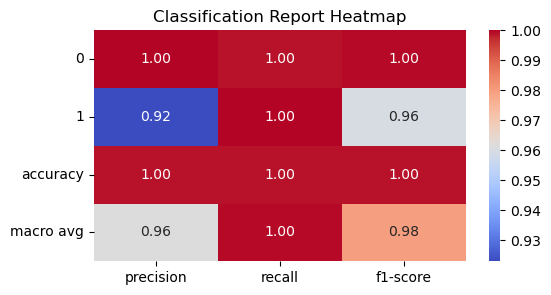

In [59]:
    """Display classification report as a heatmap."""
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    plt.figure(figsize=(6, 3))
    sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Classification Report Heatmap")
    plt.show()

In [60]:
# Extract and display decision rules
tree_rules = export_text(dt_clf, feature_names=['mass_earth', 'radius_earth', 'orbital_radius', 'eccentricity'])
print(tree_rules)

|--- orbital_radius <= 0.38
|   |--- class: 0
|--- orbital_radius >  0.38
|   |--- radius_earth <= 2.51
|   |   |--- eccentricity <= 0.20
|   |   |   |--- mass_earth <= 8.70
|   |   |   |   |--- orbital_radius <= 2.49
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- orbital_radius >  2.49
|   |   |   |   |   |--- class: 0
|   |   |   |--- mass_earth >  8.70
|   |   |   |   |--- class: 0
|   |   |--- eccentricity >  0.20
|   |   |   |--- class: 0
|   |--- radius_earth >  2.51
|   |   |--- class: 0



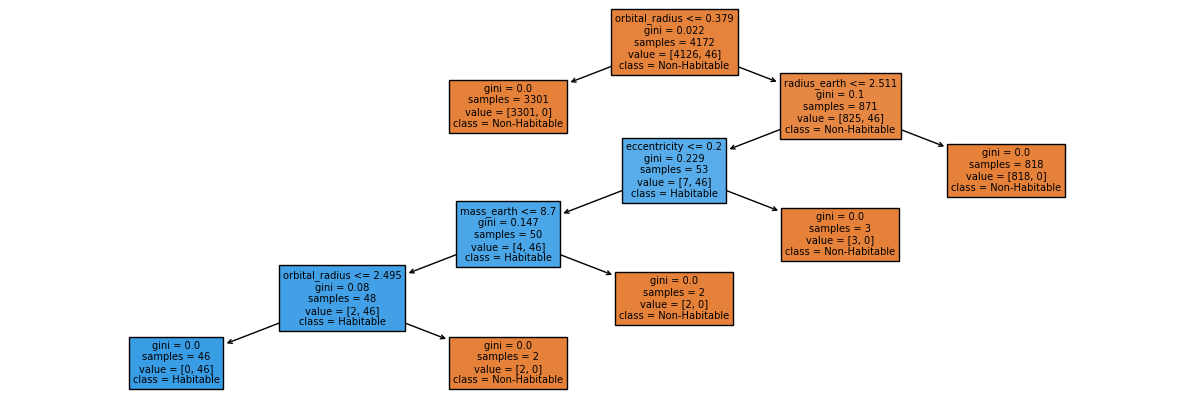

In [61]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 5))
plot_tree(dt_clf, feature_names=['mass_earth', 'radius_earth', 'orbital_radius', 'eccentricity'], class_names=['Non-Habitable', 'Habitable'], filled=True)
plt.show()

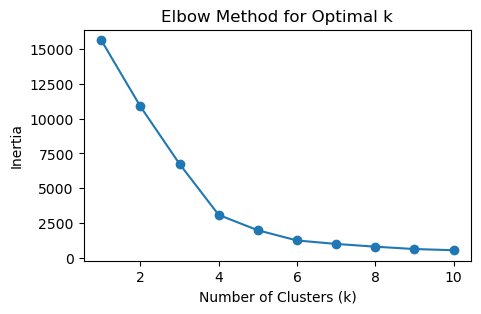

In [62]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Selecting features for clustering
cluster_features = data[['orbital_radius', 'mass_earth', 'radius_earth']].copy()

# Standardizing the data (important for clustering)
scaler = StandardScaler()
cluster_features_scaled = scaler.fit_transform(cluster_features)

# Finding optimal number of clusters using Elbow Method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cluster_features_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(5, 3))
plt.plot(k_range, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

Cluster Distribution:
 cluster
0    3673
1    1536
3       5
2       1
Name: count, dtype: int64


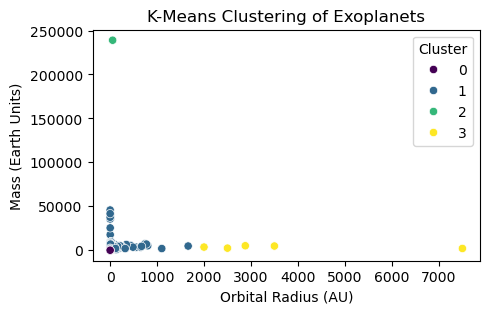

In [63]:
# Apply K-Means with the optimal k (replace 3 with the chosen value)
optimal_k = 4  # Change this based on the elbow method result
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data['cluster'] = kmeans.fit_predict(cluster_features_scaled)

# Check cluster distribution
print("Cluster Distribution:\n", data['cluster'].value_counts())

import seaborn as sns

plt.figure(figsize=(5, 3))
sns.scatterplot(x=data['orbital_radius'], y=data['mass_earth'], hue=data['cluster'], palette='viridis')
plt.xlabel("Orbital Radius (AU)")
plt.ylabel("Mass (Earth Units)")
plt.title("K-Means Clustering of Exoplanets")
plt.legend(title="Cluster")
plt.show()

In [64]:
from sklearn.cluster import DBSCAN
import numpy as np

# Fit DBSCAN (Adjust eps and min_samples as needed)
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Try different values if needed
data['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

# Count cluster distribution
print("DBSCAN Cluster Distribution:\n", data['dbscan_cluster'].value_counts())

DBSCAN Cluster Distribution:
 dbscan_cluster
 0    5179
-1      36
Name: count, dtype: int64


In [65]:
print("Number of outliers:", (data['dbscan_cluster'] == -1).sum())

Number of outliers: 36


In [66]:
# Step 1: Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data.select_dtypes(include=['float64', 'int64']))  # Apply PCA on numerical data

# Step 2: Apply DBSCAN
dbscan = DBSCAN()
data['dbscan_cluster'] = dbscan.fit_predict(X_pca)  # Cluster the PCA-transformed data

# Step 3: Plot the PCA-reduced DBSCAN clustering result
plt.figure(figsize=(5, 3))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['dbscan_cluster'], cmap='plasma', alpha=0.5)
plt.colorbar(label="DBSCAN Cluster")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering (PCA Reduced)")
plt.show()

NameError: name 'PCA' is not defined

In [ ]:
cluster_means = data.groupby('dbscan_cluster')[['mass_earth', 'radius_earth', 'orbital_radius']].mean()
print("\nCluster Characteristics:\n", cluster_means)